# Examples

For the imports of the example files, we use [pandas](https://pandas.pydata.org/), which we assume to be imported alongside `freqtools`.

In [4]:
%matplotlib inline

import freqtools as ft
import pandas as pd

### Counter data and frequency noise

In this example we import counter measurements of a beatnote of two free running Toptica DL pro and extract the corresponding frequency noise. Due to the limited internal buffer of the counter, we took three separate measurements of durations between 1 and 100 seconds and thus varying sample rates.

First, we import the data into `CounterData` objects. Each of the CounterData objects in `counter_data_list` is then converted to a `OscillatorNoise` object by using Welch's method and join them all together into one `OscillatorNoise` object:

In [5]:
files = ['Counter_1.csv', 'Counter_2.csv', 'Counter_3.csv']

noise_list = []
for f in files:
    data = pd.read_csv(f, header=7)
    counter_data = ft.CounterData(data["Frequency"].values, duration=data["Time"].values[-1])
    noise_list.append(counter_data.to_oscillator_noise(method="welch"))

# Merge the noise data into one dataset
noise = noise_list[0]
noise.join(noise_list[1:2]) # join the 2nd and 3rd counter data to the 1st one
noise.label = 'laser beatnote'

We are interestd in the Frequency noise of one laser, so we have to divide the PSD by 2 (assuming uncorrelated noise). Changing the `values` property will automatically cause all representations to be recalculated.

In [6]:
noise.values = noise.values / 2

For linewidth calculation, we create a `BetaLine` object.

In [7]:
beta_line = ft.BetaLine()

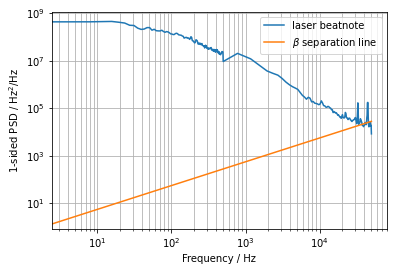

In [8]:

fig, ax = noise.plot()
beta_line.plot(noise.freqs, ax=ax)
ax.legend()

The linewidth of the laser can be calculated from the intersection of the $\beta$ separation line and the frequency noise. It can be calculated like this:

In [9]:
beta_line.linewidth(noise) / 1e6

0.27155627776409696

This means, an linewidth of roughly 270 kHz at 1 ms (the default value for `linewidth`).

### Spectrum analyzer data

Here, we analyze the data of a phaselock between two lasers.

First, we have a look a beatnote measured with a spectrum analyzer

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Frequency / Hz', ylabel='level / dBm'>)

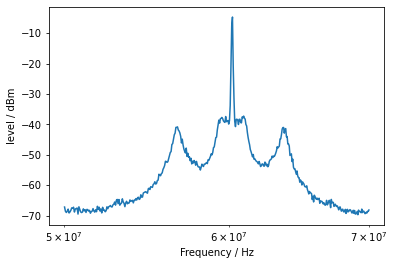

In [10]:
spec_data = pd.read_csv('laser_spectrum_analyzer_data.txt', names=["Frequency", "Amplitude"], skiprows=1, delimiter='\t')

spectrum = ft.SpectrumAnalyzerData(spec_data["Frequency"].values, spec_data["Amplitude"].values, rbw=3e5)
spectrum.plot()

We can also convert this data to phase noise (in a `OscillatorNoise` object) and plot the resulting PSD of the phase:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Frequency / Hz', ylabel='L(f) / dBc/Hz'>)

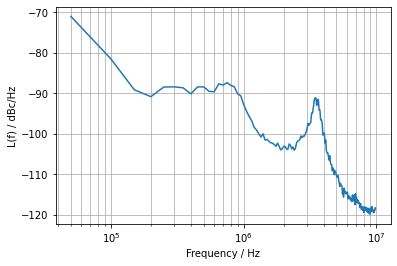

In [11]:
laser_noise_from_spec = spectrum.to_oscillator_noise()
laser_noise_from_spec.plot()

### Phase noise 

Alternatively, we record data with a Rohde&Schwartz FSW phase noise tool.

In [12]:
laser_noise_data = pd.read_csv(
    "PN_FALC_100MHz.DAT",
    names=["Frequency", "Amplitude"],
    skiprows=133,
    usecols=[0,1],
    delimiter=";")

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Frequency / Hz', ylabel='L(f) / dBc/Hz'>)

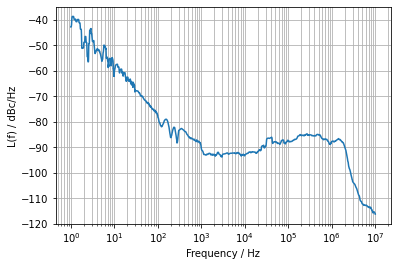

In [21]:
laser_noise = ft.OscillatorNoise(laser_noise_data["Frequency"].values,
                            laser_noise_data["Amplitude"].values,
                            representation="script_L",
                            label="Laser")
laser_noise.plot()

### Calculating impact of laser and frequency chain phase noise on atom interferometer phase noise

In this example we use the laser phase noise data from above to calculate the impact of the laser's phase noise for a Mach Zehnder atom interferometer with an interferometer time 2 T = 400 ms and a pulse time 𝜏 = 20 μs. For this we first have to consider the noisecoming from the DRO that is used to lock the lasers at 6.8 GHz. We load the data and plot them together.

In [23]:
dro_noise_data = pd.read_csv(
    "DRO_68_ref10M_pn.DAT",
    names=["Frequency", "Amplitude"],
    skiprows=120,
    usecols=[0,1],
    delimiter=";")

In [24]:
dro_noise = ft.OscillatorNoise(dro_noise_data["Frequency"].values,
                            dro_noise_data["Amplitude"].values,
                            representation="script_L",
                            label="DRO")

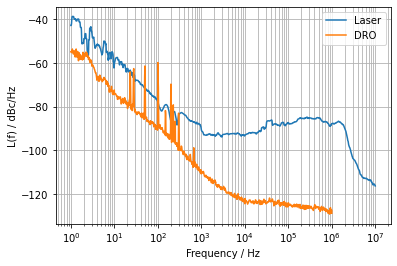

In [25]:
fig, ax = laser_noise.plot()
dro_noise.plot(ax=ax)
ax.legend()

Next, we have to consider the transfer function of the atom interferometer. It is a highly oscillatory function with a low-pass behaviour which an be verified by calling its `plot_magnitude` method. Here we scale the transfer function with $(k_\text{eff} T^2)$ with $k_\text{eff} = \frac{4\pi}{780\,\mathrm{nm}}$ to get it in units of m/s²/rad.

In [26]:
mz_tf = ft.MachZehnderTransferFunction(T=260e-3, tau=40e-6, convert_to_g=True)

To calculate the atom interferometer noise, we first have to scale the phase noise with the squared magnitude of the transfer function and integrate over all frequencies of interest:

\begin{equation}
\sigma_{\text{AI}}^2 = \int_{f_0}^\infty |H_\text{AI}(2\pi f)|^2 \cdot S_\phi(f) \mathrm{d}f
\end{equation}

We leave the lower integration bound $f_0$ as a free parameter in this equation and inegrate all phasenoies above this frequency, or conversly, up to a certain measurement time. $S_\phi$ here is the 1-sided PSD of phase. To conversion from $L(f)$ to $S_\phi$ is done automatically, as can be seen by looking at the `representation` argument of the scaled phase noise or the plot label. 

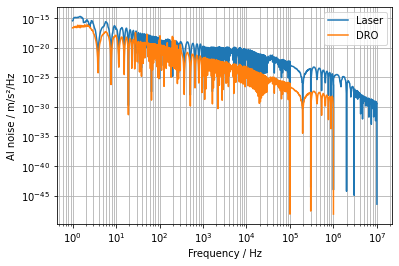

In [29]:
laser_noise_scaled = mz_tf.scale_noise(laser_noise)
dro_noise_scaled = mz_tf.scale_noise(dro_noise)

fig, ax = laser_noise_scaled.plot()
dro_noise_scaled.plot(ax=ax)
ax.legend()

The last step now is the integration over all relevant frequencies. In this plot integration takes place from the right sight and for each frequency the accumulated phase noise of all higher frequencies is displayed.

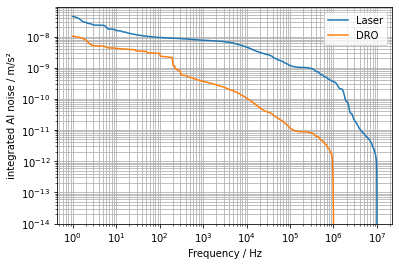

In [31]:
laser_noise_rms = ft.calc_rms_noise(laser_noise_scaled)
dro_noise_rms = ft.calc_rms_noise(dro_noise_scaled)

fig, ax = laser_noise_rms.plot()
dro_noise_rms.plot(ax=ax)
ax.legend()